# Assignment 3: Clustering California Housing with K-means

### CS 4501 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://amp.businessinsider.com/images/573de0b88d3eaea27198a55d-960-480.jpg)

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture 9 or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you (for free) from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment. 

In [1]:
# You might want to use the following package
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Your code goes here for this section.
import pandas as pd
import os

def load_housing_data(housing_path=""):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


housing = load_housing_data()


housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [2]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

<Figure size 2000x1500 with 9 Axes>

In [3]:
import numpy as np 

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

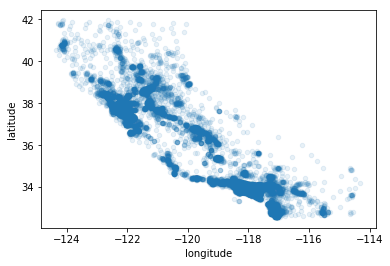

In [4]:
housing.plot(kind="scatter", x="longitude", y="latitude",alpha=0.1)

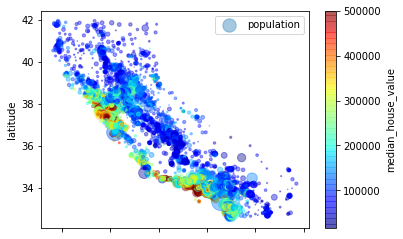

In [5]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population",
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
) 
plt.legend()

In [6]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
income_cat            0.643892
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [7]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.3, random_state=42)

X_test = test_set.drop("median_house_value", axis=1)
X_train = train_set.drop("median_house_value", axis=1)

y_test = test_set["median_house_value"].copy()
y_train = train_set["median_house_value"].copy()

In [8]:
# SAVING THESE FOR LATER
long = list(X_train['longitude'])

long_mean = np.mean(long)
long_std = np.std(long)
long_idx = 0

lat = list(X_train['latitude'])

lat_mean = np.mean(lat)
lat_std = np.mean(lat)
lat_idx = 1

list_of_features = X_train.columns

numofsamples = X_train.shape[0]

print(long_mean, long_std)
print(lat_mean, lat_std)
print(list_of_features)
print(numofsamples)

-119.58410229789591 2.0028608960389045
35.650669296788486 35.650669296788486
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'income_cat'],
      dtype='object')
14448


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])


In [10]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20
    

num_attribs = list(housing.drop("median_house_value", axis=1).drop("ocean_proximity", axis=1))

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
    ])

X_test = full_pipeline.fit_transform(X_test)
X_train = full_pipeline.fit_transform(X_train)

In [11]:
X_test.shape

(6192, 9)

In [12]:
X_train.shape

(14448, 9)

- - -
## 2. IMPLEMENTING K-MEANS (40 pts)

You must implement your own version of K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In our case, a centroid is just the average of all data in a cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure** below.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in housing assignment occurs between iterations.

**Distance Measures:** Your implementation must include the Euclidean distance which is:
$d(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}2]{\sum\limits_{i=1}^n|x_i - y_i|^2}$

**Implementation Notes:** Note that your functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical.

In [13]:
# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
import random

def k_means(k, dataset):
    features = dataset.shape[1]
    
    min = {}
    for x in range(1, features+2):
        min[x] = 10000
    
    max = {}
    for x in range(1, features+1):
        max[x] = -10000
    
    for x in dataset:
        for y in range(0, len(x)):
            if min[y+1] > round(x[y]):
                min[y+1] = round(x[y])
            if max[y+1] < round(x[y]):
                max[y+1] = round(x[y])

    #GENERATE RANDOM CENTROIDS
    centroids = []                 #np.array([1,2,3])
    temp = []
    for cent in range(0, k):
        r = random.randint(0, len(dataset))
        if r not in temp:
            centroids.append(dataset[r])
        temp.append(r)
    
    #print(centroids)   
        
    for iter in range(100):
        cent = {}   #holds closest points to i'th centroid
        for i in range(k):
            cent[i] = []

        for m in dataset:
            dists = []
            for l in range(0, k):
                d = np.linalg.norm(centroids[l] - m)
                dists.append(d)

            a = np.array(dists) 
            idx_min = np.where(a == a.min())
            (cent[idx_min[0][0]]).append(m)
            
        for i in range(k):
            centroids[i] = np.mean(cent[i], axis=0)
            
    #returning array of centroids, dict of clusters
    return centroids, cent


def sse(centroids, clusters):
    k = len(centroids)
    
    cents = []
    
    for i in range(k):
        sum = 0
        for j in clusters[i]:
            d = np.linalg.norm(centroids[i] - j)
            sum += (d**2)
            
        cents.append(sum)
        
    return np.sum(cents)

- - -
## 3. CLUSTERING HOUSING INTO REGIONS (40 pts)

Now that you have implemented the K-Means as the clustering algorithm. Applying the algorithm for k=2 clusters to see if you can split California into a Northern and Southern regions.

* **Cluster the data:** Write down the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. You should get a plot that looks roughly in the shape of California (see Chapter 2 for more details). Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? It will definitely be helpful to have a map of California handy.

* **Change the number of clusters:** Change k from 2 to 10 and repeat the clustering process above. Record cluster means and standard deviations. When you change k, do any additional patterns emerge? If so, what are they? Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.

**Implementation Notes:** For each k, report the training and validation accuracy. Identify the k with the highest validation accuracy, and report the test accuracy with this choice of k. Note: if multiple values of k result in the highest validation accuracy, then report test accuracies for all such values of k. Then, plot the data points with different markers corresponding to different classes. Repeat this process for all k and discuss the smoothness of the regions as k increases.


In [14]:
# Your code goes here
def clusterSTD(cluster):
    return np.std(cluster)

def clusterMean(cluster):
    return np.mean(cluster)


centroids, clusters = k_means(2, X_train)

err = sse(centroids, clusters)

print("SSE:", err)

for i in range(len(centroids)):
    print("-----------------------------------")
    print("Centroid", i, ":", centroids[i])
    print("Stdev :", clusterSTD(clusters[i]))
    print("Mean :", clusterMean(clusters[i]))


SSE: 99198.10106166945
-----------------------------------
Centroid 0 : [-0.02148485  0.0203946   0.11542484 -0.25720447 -0.26576139 -0.24150167
 -0.2646916  -0.02377759 -0.02954171]
Stdev : 0.8238269999508449
Mean : -0.10757153760708173
-----------------------------------
Centroid 1 : [ 0.16328484 -0.154999   -0.87722878  1.95475397  2.01978657  1.8354127
  2.01165618  0.1807097   0.22451699]
Stdev : 1.6387882273183207
Mean : 0.8175436858138233


In [15]:
print(numofsamples)

14448


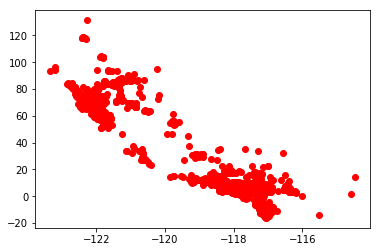

In [16]:
from scipy import stats as st
import math

longNew = []
latNew = []
k = 2   #centroids

cl = clusters[0]
c = len(cl)
for i in cl:
    longTemp = (i[long_idx]*long_std) + long_mean
    latTemp = (i[lat_idx]*lat_std) + lat_mean
        
#         if type(latTemp) != float:
#             print(type(latTemp))
#             print(latTemp)
#             print(i[lat_idx])
#             print()

    longNew.append(float(longTemp))
    latNew.append(float(latTemp))
    
    
longNew1 = []
latNew1 = []
cl = clusters[1]
c = len(cl)
for i in cl:
    longTemp = (i[long_idx]*long_std) + long_mean
    latTemp = (i[lat_idx]*lat_std) + lat_mean

    longNew1.append(float(longTemp))
    latNew1.append(float(latTemp))

    
import matplotlib.pyplot as plt
# print(len(longNew))
# print(len(latNew))

# print(longNew)

plt.plot(longNew1, latNew1, 'ro')
# plt.axis([-125,-110,0,100])
plt.show()

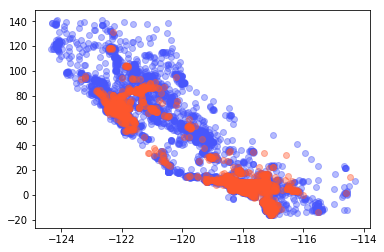

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


for u in range(0, 2):
    if u == 0:
        plt.scatter(longNew, latNew, color=[0.28039216, 0.33815827, 0.98516223], alpha=0.4)
    elif u == 1:
        plt.scatter(longNew1, latNew1, color=[1, 0.33815827, 0.17162568], alpha=0.4)

In [18]:
# k = 10 STARTING HERE


centroids, clusters = k_means(10, X_train)

err = sse(centroids, clusters)

print("SSE:", err)

for i in range(len(centroids)):
    print("-----------------------------------")
    print("Centroid", i, ":", centroids[i])
    print("Stdev :", clusterSTD(clusters[i]))
    print("Mean :", clusterMean(clusters[i]))


SSE: 39910.578034579856
-----------------------------------
Centroid 0 : [-1.15590364  0.95571498 -0.1866898  -0.02746167 -0.28809954 -0.2312207
 -0.25361539  1.17236338  1.31973968]
Stdev : 0.9747076140393324
Mean : 0.14498081153268214
-----------------------------------
Centroid 1 : [ 0.70145979 -0.77852265 -0.59858077  0.3475721  -0.12128925 -0.07643282
 -0.09779919  2.43788391  1.87560845]
Stdev : 1.2425909644063242
Mean : 0.4099888416074326
-----------------------------------
Centroid 2 : [ 0.8103446  -0.79104402 -0.44774293  0.55344558  0.80904427  0.78415823
  0.78631063 -0.28780787 -0.27144637]
Stdev : 0.8188567512121923
Mean : 0.2161402344455055
-----------------------------------
Centroid 3 : [ 0.82454477 -0.73543465 -0.66548509 -0.41655566 -0.31170047 -0.32145716
 -0.34027788 -0.56626885 -0.62763102]
Stdev : 0.6447791995725038
Mean : -0.35114066569319835
-----------------------------------
Centroid 4 : [-0.95997478  1.20987293 -0.69127089 -0.05886587 -0.00885172 -0.10037004


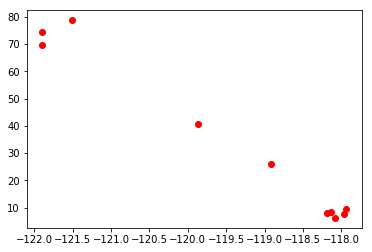

In [19]:
from scipy import stats as st
import math

longNew = []
latNew = []
k = 10   #centroids

cl = clusters[0]
c = len(cl)
for i in cl:
    longTemp = (i[long_idx]*long_std) + long_mean
    latTemp = (i[lat_idx]*lat_std) + lat_mean
        
    longNew.append(float(longTemp))
    latNew.append(float(latTemp))
        
longNew1 = []
latNew1 = []
cl = clusters[1]
c = len(cl)
for i in cl:
    longTemp = (i[long_idx]*long_std) + long_mean
    latTemp = (i[lat_idx]*lat_std) + lat_mean

    longNew1.append(float(longTemp))
    latNew1.append(float(latTemp))


longNew2 = []
latNew2 = []
cl = clusters[2]
c = len(cl)
for i in cl:
    longTemp = (i[long_idx]*long_std) + long_mean
    latTemp = (i[lat_idx]*lat_std) + lat_mean

    longNew2.append(float(longTemp))
    latNew2.append(float(latTemp))
    

longNew3 = []
latNew3 = []
cl = clusters[3]
c = len(cl)
for i in cl:
    longTemp = (i[long_idx]*long_std) + long_mean
    latTemp = (i[lat_idx]*lat_std) + lat_mean

    longNew3.append(float(longTemp))
    latNew3.append(float(latTemp))

    
longNew4 = []
latNew4 = []
cl = clusters[4]
c = len(cl)
for i in cl:
    longTemp = (i[long_idx]*long_std) + long_mean
    latTemp = (i[lat_idx]*lat_std) + lat_mean

    longNew4.append(float(longTemp))
    latNew4.append(float(latTemp))

    
longNew5 = []
latNew5 = []
cl = clusters[5]
c = len(cl)
for i in cl:
    longTemp = (i[long_idx]*long_std) + long_mean
    latTemp = (i[lat_idx]*lat_std) + lat_mean

    longNew5.append(float(longTemp))
    latNew5.append(float(latTemp))

    
longNew6 = []
latNew6 = []
cl = clusters[6]
c = len(cl)
for i in cl:
    longTemp = (i[long_idx]*long_std) + long_mean
    latTemp = (i[lat_idx]*lat_std) + lat_mean

    longNew6.append(float(longTemp))
    latNew6.append(float(latTemp))
    
    
longNew7 = []
latNew7 = []
cl = clusters[7]
c = len(cl)
for i in cl:
    longTemp = (i[long_idx]*long_std) + long_mean
    latTemp = (i[lat_idx]*lat_std) + lat_mean

    longNew7.append(float(longTemp))
    latNew7.append(float(latTemp))
    
    
longNew8 = []
latNew8 = []
cl = clusters[8]
c = len(cl)
for i in cl:
    longTemp = (i[long_idx]*long_std) + long_mean
    latTemp = (i[lat_idx]*lat_std) + lat_mean

    longNew8.append(float(longTemp))
    latNew8.append(float(latTemp))


longNew9 = []
latNew9 = []
cl = clusters[9]
c = len(cl)
for i in cl:
    longTemp = (i[long_idx]*long_std) + long_mean
    latTemp = (i[lat_idx]*lat_std) + lat_mean

    longNew9.append(float(longTemp))
    latNew9.append(float(latTemp))
    
    
longNew10 = []
latNew10 = []
cl = centroids
c = len(cl)
for i in cl:
    longTemp = (i[long_idx]*long_std) + long_mean
    latTemp = (i[lat_idx]*lat_std) + lat_mean

    longNew10.append(float(longTemp))
    latNew10.append(float(latTemp))
    
    
import matplotlib.pyplot as plt

plt.plot(longNew10, latNew10, 'ro')
plt.show()

#Looks like there is really only 3 or 4  clusters, 10 might be overkill

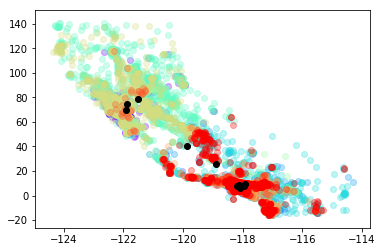

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, 10))
for u in range(0, 11):
    if u == 0:
        plt.scatter(longNew, latNew, color=colors[0], alpha=0.3)
    elif u == 1:
        plt.scatter(longNew1, latNew1, color=colors[1], alpha=0.3)
    elif u == 2:
        plt.scatter(longNew2, latNew2, color=colors[2], alpha=0.3)
    elif u == 3:
        plt.scatter(longNew3, latNew3, color=colors[3], alpha=0.3)
    elif u == 4:
        plt.scatter(longNew4, latNew4, color=colors[4], alpha=0.3)
    elif u == 5:
        plt.scatter(longNew5, latNew5, color=colors[5], alpha=0.3)
    elif u == 6:
        plt.scatter(longNew6, latNew6, color=colors[6], alpha=0.3)
    elif u == 7:
        plt.scatter(longNew7, latNew7, color=colors[7], alpha=0.3)
    elif u == 8:
        plt.scatter(longNew8, latNew8, color=colors[8], alpha=0.3)
    elif u == 9:
        plt.scatter(longNew9, latNew9, color=colors[9], alpha=0.3)
    elif u == 10:
        plt.scatter(longNew10, latNew10, color=[0,0,0])
        
#THE BLACK POINTS ARE THE CENTER OF THE CENTROIDS
#THE DIFFERNT COLORS ARE THE INSTANCES IN EACH CENTROID

In [21]:
# # Your paragraph goes here for this section

############# K = 2
# Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found?
# For k = 2, my mean and stdev were as listed below:
# SSE: 99198.072985219
# -----------------------------------
# Centroid 0 : [ 0.16290171 -0.15448513 -0.87701325  1.95753017  2.02385188  1.83895922
#   2.01573883  0.17830069  0.22352319]
# Stdev : 1.6401350118796176
# Mean : 0.8188119233624815
# -----------------------------------
# Centroid 1 : [-0.02136228  0.02025856  0.115008   -0.25670266 -0.26539982 -0.24115374
#  -0.26433591 -0.02338164 -0.02931193]
# Stdev : 0.823968749310336
# Mean : -0.10737571217663454
#
# The two centroids were far from each other, but they represented to different populations. There were many more people 
# in the second cluster on my particular run (could be in cluster one for other run depending on initial placement). However
# it is important to notice that one cluster takes up more of the coastal areas such as San Fran and Silicon Valley.
# Whereas the other cluster is mostly inland, not near the edge of the state of California. This could represent a significant
# wealth gap and living siutation where more low income folks live in the inner state.

# How do they compare with what you know about cities and areas in California? 
# The main California cities are very much concentrated on the coast, so this makes a lot of sense. Most of the places of
# interest are located where once of the clusters resulted for me. The other cluster takes up a lot of the non-interesting
# places.

# What can you attribute the gaps to?
# We could easily attribute this to living conditions and use of land in the area. Where coastal cities are used more
# by big tech firms and luxury companies. The inner state may be used for farming, creating a more rural-ish feel. The 
# overall living environment may also result in the splits. It is interesting looking at the gerrymandering of CA, as 
# this may give insight into why it formed in the way it did! Furthermore, we could attribute it to the income disparities
# between the two areas, which is a direct result of the capital and labor available to that area.

In [22]:
############# K = 1
# Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found?
# For k = 10, my mean and stdev were as listed below:
# SSE: 39722.760250273335
# -----------------------------------
# Centroid 0 : [ 0.32460569 -0.26539767 -1.40014298  6.56184042  6.22786551  6.1123334
#   6.26823372  0.44212984  0.55207499]
# Stdev : 3.678717887386473
# Mean : 2.7581714357889635
# -----------------------------------
# Centroid 1 : [ 0.74599745 -0.79154505  0.46799954 -0.42274129 -0.45488996 -0.39702044
#  -0.43647777  0.10126056  0.24880927]
# Stdev : 0.6387942735862499
# Mean : -0.10428974259335089
# -----------------------------------
# Centroid 2 : [ 0.72389302 -0.68886444  0.35592215 -0.53196783 -0.37800391 -0.26461863
#  -0.38937483 -0.91747779 -1.09604236]
# Stdev : 0.7156559086219757
# Mean : -0.35405940121985735
# -----------------------------------
# Centroid 3 : [ 0.79239707 -0.84316547 -0.651486    0.13938642 -0.15381582 -0.10631488
#  -0.13254396  1.1778872   1.40317307]
# Stdev : 0.9029769253208082
# Mean : 0.1806130702271744
# -----------------------------------
# Centroid 4 : [ 0.04338529 -0.02904428 -0.96188074  2.39176148  2.42112807  2.16773023
#   2.42138265  0.2675949   0.33374931]
# Stdev : 1.538952563347914
# Mean : 1.0062007693345052
# -----------------------------------
# Centroid 5 : [-1.16935885  0.96424181 -0.05020682 -0.11635724 -0.35558062 -0.31532743
#  -0.32524293  1.04257939  1.29302175]
# Stdev : 0.9393817394020207
# Mean : 0.1075298947573181
# -----------------------------------
# Centroid 6 : [-1.11455401  1.18925355  0.57701029 -0.49241764 -0.47089264 -0.51464528
#  -0.48753021 -0.56196515 -0.62046491]
# Stdev : 0.8415348957709351
# Mean : -0.2773562231338317
# -----------------------------------
# Centroid 7 : [ 0.85736978 -0.82692492 -0.49097461  0.47138332  0.75353537  0.71772779
#   0.72517413 -0.36752575 -0.36083111]
# Stdev : 0.8227268156434699
# Mean : 0.1643259989195193
# -----------------------------------
# Centroid 8 : [ 0.04350312 -0.24644089  0.4458318  -0.163759   -0.55082122 -0.50402426
#  -0.53549369  3.55496923  1.88462259]
# Stdev : 1.51944167478099
# Mean : 0.4364875198329971
# -----------------------------------
# Centroid 9 : [-0.95076738  1.06459457 -0.72425731  0.33425283  0.38819061  0.27837843
#   0.38077301 -0.29030812 -0.29286742]
# Stdev : 0.8171451552160481
# Mean : 0.02088769002431192
#
# These clusters have a much more noticeable difference and less overlap in terms of physical regions. You can notice a very
# clear north and south split and the mini clusters within those north and south regions (as in, like the coast, inner state).
# However, it is  also pretty clear that 10 centroids are not needed, as there are multiple centroids (the black dots), 
# which are in the same general area. It seems as if three or four centroids would have been enough.
#
# No additional problems seemed to have emerged other than cluster overlapping and way longer runtime.

# How do they compare with what you know about cities and areas in California? 
# This, more so than k = 2, shows the stratified-ness of the state of california. It becomes more apparent which regions
# have what economic purposes and it would be  interesting to do a full on economic study using this and small business data.
# 

# What can you attribute the gaps to?
# These attribute gaps may go deeper than simply the income. It may be saying more about the house structures and families.
# We may need to look at the dataset closer and look at the means of each housing column by cluster to see what it really
# means to be a part of cluster one versus cluster ten and see what the inherent differences are.

- - -
## 4. WRITING ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (10 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting).

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge. 



Based on the initial statement, the problem here is clearly that there is a lack of afforable housing in the areas where there is a growing population. This problem can not simply be looked at through the scope of individual income and the Californian housing market, but we must also consider the path of the United States overall economy and housing market. We have put more of our economy into the service sector than any other nation in the world and California is one of the leading states in the U.S. in terms of service ouput. This obviously means that the population must grow in order to satisfy this growing need for labor. However since land in inherenly a scarace resource, to not cause over crowdedness in the cities, the prices went up to compensate. This forced the California natives to be pushed out/become homeless and the California immigrants to take their place.

We see in this analysis the results of this, especially with the k=2 test, where the outer edges of the state, including the biggest cities being in one cluster. And the second cluster being the inner part of the states, where the others may have been forced to migrate. This problem is not one of the Californian housing market, but one the economy as a whole. There is no clear solution to this, as it is caused by the sheer need of mindpower in the state. One way to is dissolve places like Silicon Valley and have them move to separate corners of the country. However, there may be unforeness consequences to this, like a decrease in technological advances. Moves like splitting up the Amazon HQ to cover the east coast as well may help to alleviate the problem. And bigger companies like Google and Microsoft will need to be forced to follow suit. However only time will tell if this is a real solution to the housing crisis or if there is a bigger hand at play.

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during their OH.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4501 Assignment 3:...".

Best of luck and have fun!